# AIAp Miniproject 2

## Contents

- [Imports](#imports)

## Imports

In [16]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from sklearn import utils as sk_utils
import tensorflow as tf
from tensorflow.keras import utils as keras_utils
from tensorflow.keras import models as keras_models
from tensorflow.keras import layers as keras_layers


## Configs

In [17]:
SEED = 42

## Dataset

### b) Citation and description

For our project we used the following data:

- **Title:** Architectural Heritage Elements Dataset
- **Subtitle:** 128 (creative commons) revised
- **Version:** 1
- **Publication Date:** 2017-02-20
- **Author:** Jose Llamas
- **Organization:** Fundación CARTIF
- **Source:** https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_128%28creative_commons%29.zip
- **Media:** .jpg in .zip
- **Download:** 2024-03-26

The raw data was extracted with Windows. We then added it to our ["AIAp Miniproject 2"](https://gitlab.ost.ch/sylvester.homberger/aiap-miniproject-2) repository on the Gitlab instance of OST.

This dataset consists of 10437 RGB 64x64 jpg images classified in 11 categories:
- Altar: 828 images
- Apse: 505 images
- Bell tower: 1057 images
- Column: 1914 images
- Dome (inner): 589 images
- Dome (outer): 1175 images
- Flying buttress: 405 images
- Gargoyle (and Chimera): 1562 images
- Portal: 307 images
- Stained glass: 998 images
- Vault: 1097 images

As "flying buttress" and "portal" do not satisfy the minimal samples requirement of 500, we manually moved them out of our dataset into a separate folder. Our adjusted dataset therefore fulfils the requirements:
- RGB images of 9 classes
- Each has more than 500 samples and the total is 9725 images
- They have a resolution of 64x64 pixels

### c) Load and split data

In [18]:
data_folder = Path(os.getcwd()).parent / "data"
raw_folder = data_folder / "raw" / "Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised"

raw_train_val_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="training"
)

raw_test_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="validation"
)

raw_training_data, raw_validation_data = keras_utils.split_dataset(raw_train_val_data, left_size=0.8, shuffle=True)

label_to_class = raw_train_val_data.class_names
class_to_label = dict(zip(label_to_class, range(len(label_to_class))))

Found 9725 files belonging to 9 classes.
Using 6808 files for training.
Found 9725 files belonging to 9 classes.
Using 2917 files for validation.


## Exploratory data analysis

### Plot a few images

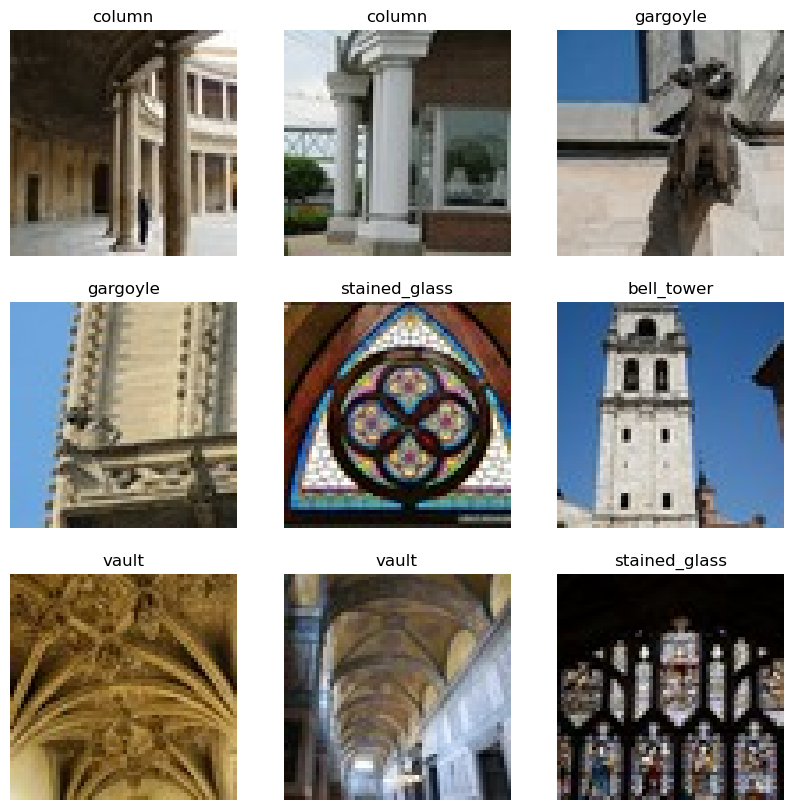

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in raw_train_val_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label_to_class[labels[i]])
    plt.axis("off")

### Samples per class

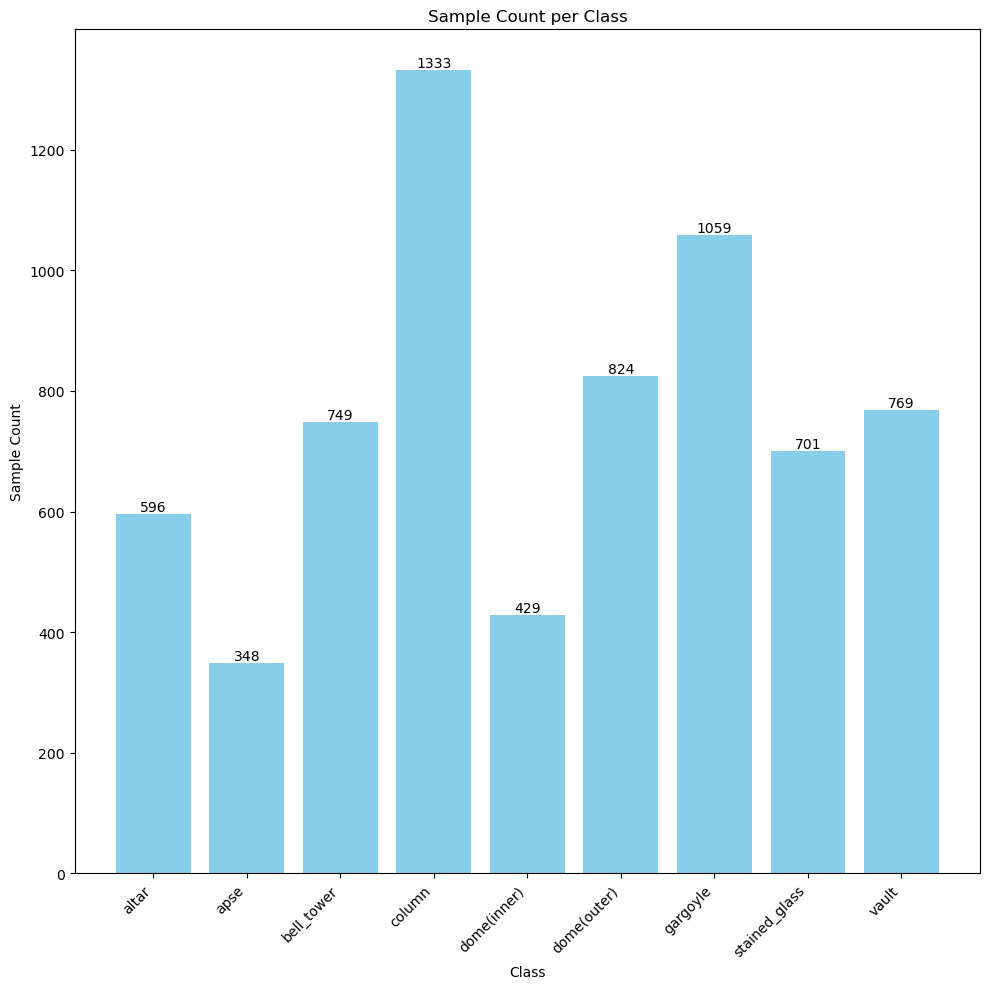

In [20]:
# Count samples per class
class_counts = raw_train_val_data.reduce(
    initial_state=tf.zeros(len(label_to_class), dtype=tf.int32),
    reduce_func=lambda count, images_labels: count + tf.math.bincount(images_labels[1], minlength=len(label_to_class)))

# Extract numbers
class_counts_values = [count.numpy() for count in class_counts]

# Plot samples per class
plt.figure(figsize=(10, 10))
bars = plt.bar(label_to_class, class_counts_values, color='skyblue')
plt.bar_label(bars, labels=class_counts_values, label_type='edge', color='black')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.title('Sample Count per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


The dataset is not balanced. Classes need to be weighted for training.

### Distribution of values

Red range: 	 0.0  -  255.0
Green range: 	 0.0  -  255.0
Blue range: 	 0.0  -  255.0


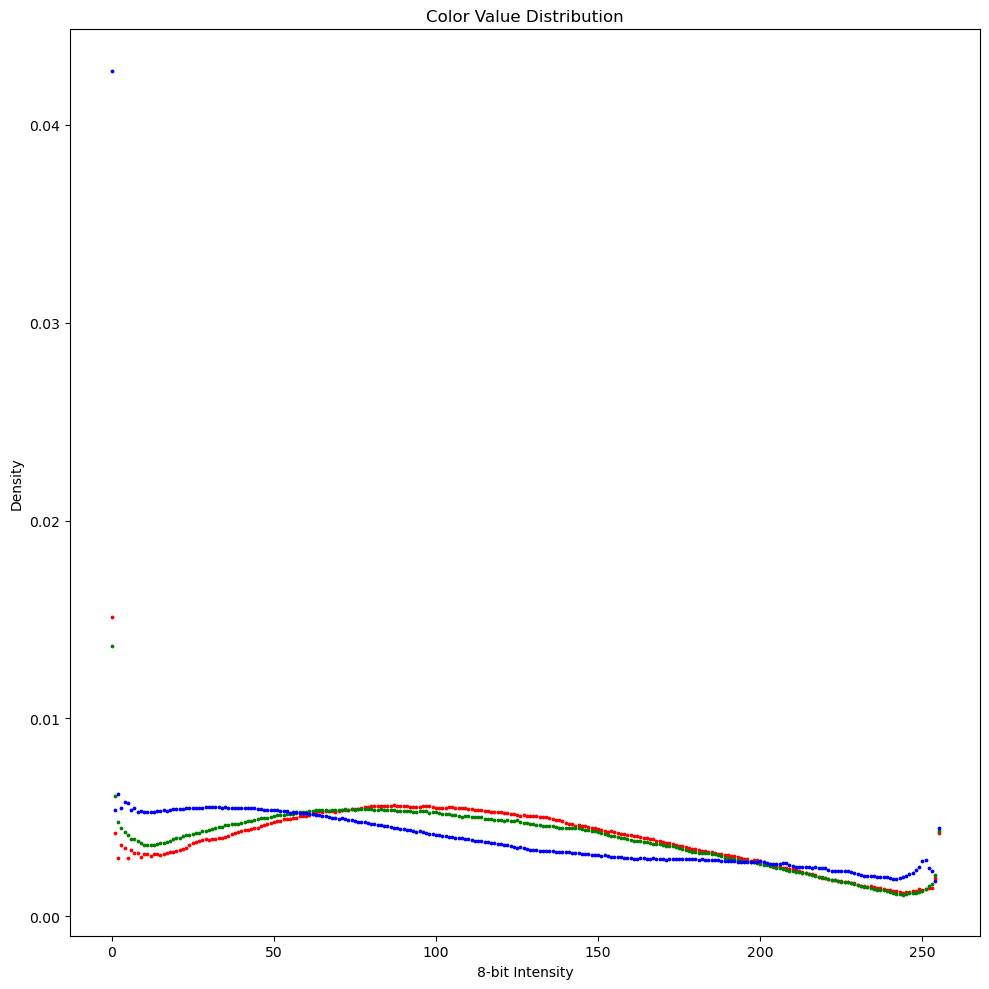

In [21]:
# Concatenate all images in the dataset
images_np = np.concatenate([images.numpy() for images, _ in raw_training_data])

# Reshape to (num_images * height * width, channels)
images_np = images_np.reshape(-1, images_np.shape[3])

# Extract RGB values
red_values = images_np[:, 0]
green_values = images_np[:, 1]
blue_values = images_np[:, 2]

# Get range of values
red_max = np.max(red_values)
red_min = np.min(red_values)
print("Red range: \t", red_min, " - ", red_max)
green_max = np.max(green_values)
green_min = np.min(green_values)
print("Green range: \t", green_min, " - ", green_max)
blue_max = np.max(blue_values)
blue_min = np.min(blue_values)
print("Blue range: \t", blue_min, " - ", blue_max)

# Calculate the distribution
red_distribution = np.histogram(red_values, bins=256, density=True)[0]
green_distribution = np.histogram(green_values, bins=256, density=True)[0]
blue_distribution = np.histogram(blue_values, bins=256, density=True)[0]

# Plot all color densities on the same plot
plt.figure(figsize=(10, 10))
plt.scatter(range(len(red_distribution)), red_distribution, color='red', s=3)
plt.scatter(range(len(green_distribution)), green_distribution, color='green', s=3)
plt.scatter(range(len(blue_distribution)), blue_distribution, color='blue', s=3)
plt.xlabel('8-bit Intensity')
plt.ylabel('Density')
plt.title('Color Value Distribution')
plt.tight_layout()

We observe significant peaks at the extreme ends of the value range (0 and 255). The underlying cause is unclear to us, as we did not generate the images ourselves. 

We observed a clear distinction in the distribution of blue intensity compared to that of red and green. While all colors demonstrate a decrease in density as intensity increases, there are notable variations among them. Specifically, red and green intensities seem to follow a somewhat normal distribution pattern, whereas blue intensity exhibits a nearly monotonic decline.

This decrease in density across intensities could potentially stem from heightened sensitivity of the camera equipment at higher levels, leading to a stretched scale. However, when examining the discrepancy between blue and the other colors, our initial online investigation did not provide immediate insights into the underlying cause of this disparity.

However, those phenomenona should not hinder meaningful model training, provided it does not systematically convey information regarding the classes.

Additionally, we need to rescale the value range from [0 - 255] to [0 - 1]. The below function will also be used for the test data later.

In [22]:
def scale_image_dataset(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization_layer(x), y))

training_data = scale_image_dataset(raw_training_data)
validation_data = scale_image_dataset(raw_validation_data)

#### Calculate class weights

In [23]:
def generate_class_weights():
    # create list of all labels
    y_train = []
    for f, l in training_data:
        y_train.extend(l.numpy())
    y_train = np.array(y_train)
    # Calculate class weights
    class_weights = sk_utils.class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train),
        y=y_train
    )
    # Convert class weights to a dictionary format
    return dict(zip(np.unique(y_train), class_weights))

## Architecture (common functions)

#### Compile and train function

In [19]:
def compile_and_train(model, epochs=10, t_data=training_data, v_data=validation_data):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model.fit(t_data, validation_data=v_data, epochs=epochs, class_weight=generate_class_weights())

#### visualize accuracy and loss function

In [56]:
def visualize_model(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(accuracy))
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.show()

#### visualize the confusion matrix

In [60]:
def calculate_confusion_matrix(model, v_data=validation_data, normalize=None):
    # Prediction
    predictions = model.predict(v_data)
    predicted_labels = np.array(np.argmax(predictions, axis=1))
    
    # True labels
    true_labels = []
    for f, l in v_data:
        true_labels.extend(l.numpy())
    true_labels = np.array(true_labels)
    return sk_metrics.confusion_matrix(true_labels, predicted_labels, normalize=normalize)

def visualize_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues_r)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(label_to_class))
    plt.xticks(tick_marks, label_to_class, rotation=45)
    plt.yticks(tick_marks, label_to_class)
    
    # Display the counts in each cell
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="black" if confusion_matrix[i, j] > thresh else "white")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()




## Architecture 1 (underfitting)

#### Model

In [73]:
underfitting_model = keras_models.Sequential()
underfitting_model.add(keras_layers.Conv2D(
    filters=4, kernel_size=(3,3), padding='same', activation='relu', input_shape=(64, 64, 3)
))
underfitting_model.add(keras_layers.MaxPooling2D())
underfitting_model.add(keras_layers.Conv2D(
    filters=4, kernel_size=9, strides=4, padding='same', activation='relu'
))
underfitting_model.add(keras_layers.MaxPooling2D())
underfitting_model.add(keras_layers.Flatten())
underfitting_model.add(keras_layers.Dense(len(label_to_class)))

#### Summary

In [74]:
underfitting_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 32, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 4)           1300      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 4)          0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 9)                

### Compile and train the model

In [75]:
underfitting_history = compile_and_train(model=underfitting_model, epochs=100)

Epoch 1/100
171/171 [==============================] - 2s 10ms/step - loss: 2.0669 - accuracy: 0.2066 - val_loss: 1.9001 - val_accuracy: 0.2922
Epoch 2/100
171/171 [==============================] - 1s 8ms/step - loss: 1.7393 - accuracy: 0.3571 - val_loss: 1.6094 - val_accuracy: 0.3744
Epoch 3/100
171/171 [==============================] - 1s 8ms/step - loss: 1.4951 - accuracy: 0.4532 - val_loss: 1.4531 - val_accuracy: 0.4435
Epoch 4/100
171/171 [==============================] - 1s 8ms/step - loss: 1.3790 - accuracy: 0.5051 - val_loss: 1.3743 - val_accuracy: 0.4890
Epoch 5/100
171/171 [==============================] - 1s 9ms/step - loss: 1.3023 - accuracy: 0.5283 - val_loss: 1.3232 - val_accuracy: 0.5073
Epoch 6/100
171/171 [==============================] - 1s 9ms/step - loss: 1.2493 - accuracy: 0.5483 - val_loss: 1.2823 - val_accuracy: 0.5272
Epoch 7/100
171/171 [==============================] - 1s 9ms/step - loss: 1.2118 - accuracy: 0.5718 - val_loss: 1.2577 - val_accuracy: 0.536

### Visualize training results

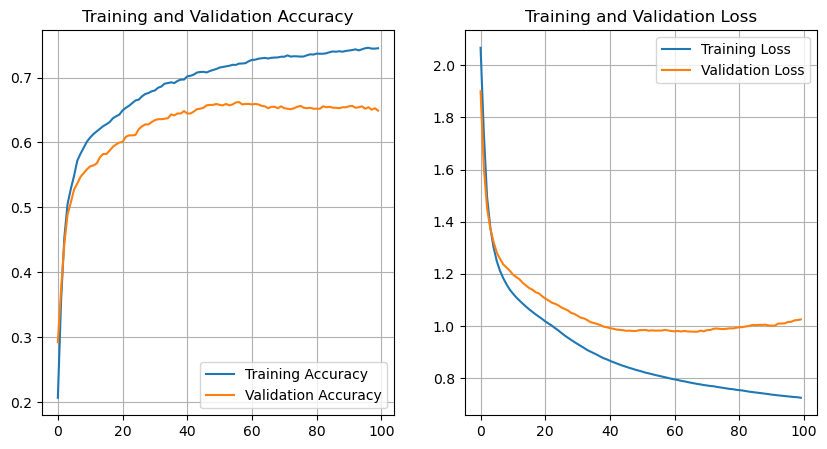

In [76]:
visualize_model(underfitting_history)

### Confusion Matrix

43/43 [==============================] - 0s 4ms/step


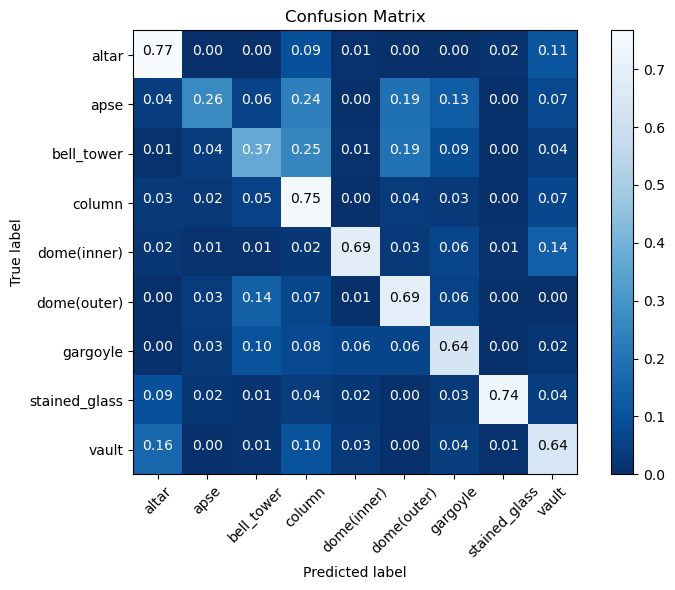

In [82]:
conf_matrix = calculate_confusion_matrix(underfitting_model,validation_data, "true")
visualize_confusion_matrix(conf_matrix)

### Discussion

## Architecture 2 (overfitting)

### Model

In [21]:
overfitting_model = keras_models.Sequential()
overfitting_model.add(keras_layers.Conv2D(
    filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(64, 64, 3)
))
overfitting_model.add(keras_layers.MaxPooling2D())
overfitting_model.add(keras_layers.Conv2D(
    filters=32, kernel_size=5, padding='same', activation='relu'
))
overfitting_model.add(keras_layers.MaxPooling2D())
overfitting_model.add(keras_layers.Conv2D(
    filters=64, kernel_size=7, padding='same', activation='relu'
))
overfitting_model.add(keras_layers.MaxPooling2D())
overfitting_model.add(keras_layers.Flatten())
overfitting_model.add(keras_layers.Dense(81))
overfitting_model.add(keras_layers.Dense(9))

### Summary

In [22]:
overfitting_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        100416    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)        

### Compile and train the model

In [20]:
overfitting_history = compile_and_train(overfitting_model)

Epoch 1/40


171/171 [==============================] - 14s 75ms/step - loss: 1.5063 - accuracy: 0.4458 - val_loss: 1.2068 - val_accuracy: 0.5815
Epoch 2/40
171/171 [==============================] - 16s 96ms/step - loss: 1.0404 - accuracy: 0.6322 - val_loss: 0.9668 - val_accuracy: 0.6645
Epoch 3/40
171/171 [==============================] - 16s 95ms/step - loss: 0.8067 - accuracy: 0.7200 - val_loss: 0.8818 - val_accuracy: 0.6909
Epoch 4/40
171/171 [==============================] - 16s 92ms/step - loss: 0.6494 - accuracy: 0.7729 - val_loss: 0.9725 - val_accuracy: 0.6784
Epoch 5/40
171/171 [==============================] - 18s 103ms/step - loss: 0.5273 - accuracy: 0.8116 - val_loss: 0.8728 - val_accuracy: 0.7225
Epoch 6/40
171/171 [==============================] - 18s 102ms/step - loss: 0.4226 - accuracy: 0.8542 - val_loss: 0.9280 - val_accuracy: 0.6953
Epoch 7/40
171/171 [==============================] - 19s 114ms/step - loss: 0.3631 - accuracy: 0.8718 - val_loss: 1.1116 - val_accuracy: 0.6953


### Visualize training results

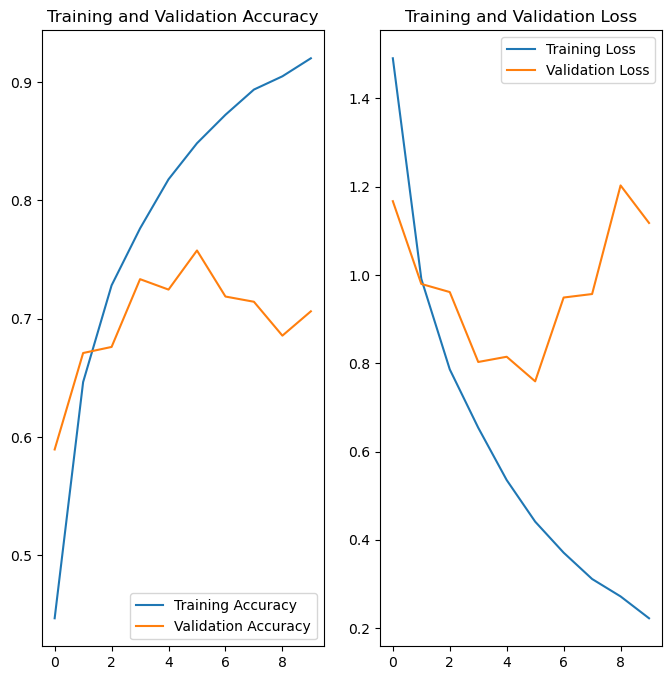

In [74]:
visualize_model(overfitting_history)

### Confusion Matrix

### Discussion

## Architecture 2 (optimized)

## Quantification of the model performance

## Discussion